# Train data-based models

In [1]:
import numpy as np
import do_mpc
import matplotlib.pyplot as plt
import importlib
import pickle
import tensorflow as tf
from tensorflow import keras
import time
import pandas as pd
import sys
import os
import functions

sys.path.append(os.path.join(sys.path[0],'BLL'))
import bayesianlastlayer as bll
import tools

Load data from pandas dataframe

In [2]:
data = pd.read_pickle('./../Data generation/results/MSMPR1_train_500.pkl')

print('Training data contains',data.shape[0],'samples')

# Outputs
T, T_j, c, L10, mu_0, mu_1, mu_2 = functions.calculate_outputs(data)

# Inputs
T_j_in, F_j, F_feed = functions.calculate_inputs(data)

# Test data
test = pd.read_pickle('./../Data generation/results/MSMPR1_test.pkl')
no_stages_test = int(test.shape[1]/8)
print('Loaded test simulation used',no_stages_test,'stage/s')

# Outputs
T_test, T_j_test, c_test, L10_test, mu_0_test, mu_1_test, mu_2_test = functions.calculate_outputs(test)

# Inputs
T_j_in_test, F_j_test, F_feed_test = functions.calculate_inputs(test)

# Scale moments with mu_0 (mu_0 stays constant)
mu_0 = mu_0/mu_0
mu_1 = mu_1/mu_0
mu_2 = mu_2/mu_0

mu_0_test = mu_0_test/mu_0_test
mu_1_test = mu_1_test/mu_0_test
mu_2_test = mu_2_test/mu_0_test

Training data contains 500 samples
Loaded test simulation used 1 stage/s


Visualize training data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


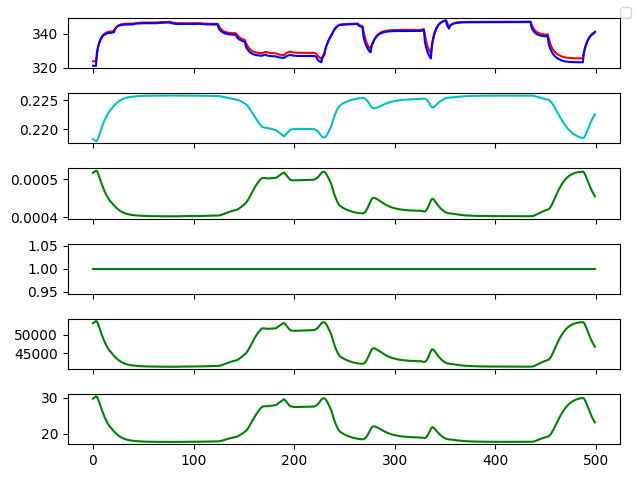

In [3]:
fig, ax = plt.subplots(6,1,sharex='col',sharey='row')

ax[0].plot(T,c='r')
ax[0].plot(T_j,c='b')
ax[1].plot(c,c='c')
ax[2].plot(L10,c='g')
ax[3].plot(mu_0,c='g')
ax[4].plot(mu_1,c='g')
ax[5].plot(mu_2,c='g')

fig.legend()
fig.tight_layout()

Setup training

In [4]:
# Select measured states
y = np.concatenate((T,T_j,c,L10,mu_0,mu_1,mu_2),axis=1)
# y = np.concatenate((T,T_j,c,L43,CV),axis=1)
u = np.concatenate((T_j_in,F_j,F_feed),axis=1)

# Select measured states
y_test = np.concatenate((T_test,T_j_test,c_test,L10_test,mu_0_test,mu_1_test,mu_2_test),axis=1)
# y_test = np.concatenate((T_test,T_j_test,c_test,L43_test,CV_test),axis=1)
u_test = np.concatenate((T_j_in_test,F_j_test,F_feed_test),axis=1)

# Create inputs and outputs withou NARX
l = 1
NN_in, NN_out = functions.narx_io(y,u,l)
NN_train = (NN_in, NN_out)

# Scale data
train, val = tools.split(NN_train, test_size=0.1)
scaler_NN = tools.Scaler(*train)
train_scaled = scaler_NN.scale(*train)
val_scaled = scaler_NN.scale(*val)

Train standard NN

In [5]:
inputs = keras.Input(shape=(NN_in.shape[1],))
dense_1 = keras.layers.Dense(30,activation='tanh')(inputs)
dense_2 = keras.layers.Dense(30,activation='tanh')(dense_1)
dense_3 = keras.layers.Dense(30,activation='linear')(dense_2)
outputs = keras.layers.Dense(NN_out.shape[1],activation='linear')(dense_2)

model_NN = keras.Model(inputs, outputs)
model_NN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 30)                330       
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 7)                 217       
                                                                 
Total params: 1,477
Trainable params: 1,477
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000
12/12 [==============================] - 0s 12ms/step - loss: 0.9394 - val_loss: 0.6182
Epoch 2/2000
12/12 [==============================] - 0s 3ms/step - loss: 0.4809 - val_loss: 0.3032
Epoch 3/2000
12/12 [==============================] - 0s 3ms/step - loss: 0.2314 - val_loss: 0.1462
Epoch 4/2000
12/12 [==============================] - 0s 3ms/step - loss: 0.1099 - val_loss: 0.0786
Epoch 5/2000
12/12 [==============================] - 0s 3ms/step - loss: 0.0629 - val_loss: 0.0570
Epoch 6/2000
12/12 [==============================] - 0s 3ms/step - loss: 0.0468 - val_loss: 0.0458
Epoch 7/2000
12/12 [==============================] - 0s 4ms/step - loss: 0.0383 - val_loss: 0.0378
Epoch 8/2000
12/12 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0324
Epoch 9/2000
12/12 [==============================] - 0s 3ms/step - loss: 0.0284 - val_loss: 0.0285
Epoch 10/2000
12/12 [==============================] - 0s 3ms/step - loss: 0.0253 - val_loss: 0.025

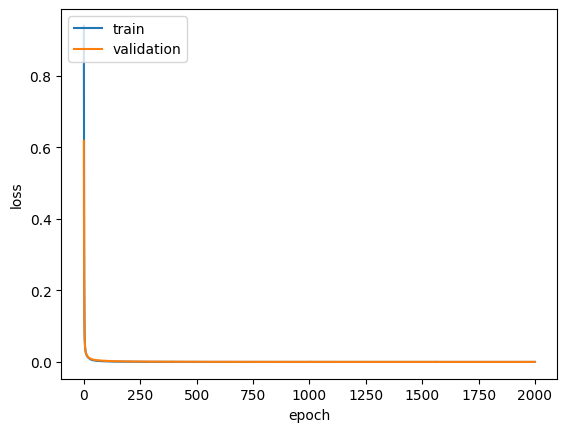

In [6]:
model_NN.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.MeanSquaredError())

# model_NN.compile(optimizer=keras.optimizers.experimental.AdamW(), loss=keras.losses.MeanSquaredError())

# history = model_NN.fit(narx_in_reduced, train_scaled[1], epochs = 100, batch_size = 32, validation_split=0.2)
history = model_NN.fit(*train_scaled, epochs = 2000, batch_size = 32, validation_split=0.2)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
 
plt.show()

Test model

In [7]:
# Test model
x_0 = y_test[0].reshape(1,-1)
x_narx = x_0.reshape(1,-1)

t_sim = y_test.shape[0]

for i in range(l-1):
    x_narx = np.concatenate((x_narx,x_0),axis=0)
for i in range(l,t_sim):
    print(i)
    x_this_step = []
    u_this_step = []
    x_this_step.append(x_narx[-l:])
    u_this_step.append(u_test[i-l:i])
    
    x_this_step = np.array(x_this_step)
    u_this_step = np.array(u_this_step)
    
    narx_in_this_step = np.concatenate((x_this_step.reshape(1,-1),u_this_step.reshape(1,-1)),axis=1).reshape(1,-1)
    narx_in_this_step_sc = scaler_NN.scale(narx_in_this_step)[0]

    narx_in_this_step_reduced = narx_in_this_step_sc
    
    x_NN_sc = model_NN.predict(narx_in_this_step_reduced, verbose=False)
    x_NN = scaler_NN.unscale(narx_in_this_step_sc,x_NN_sc)[1].astype(float)
    
    x_narx = np.concatenate((x_narx,x_NN),axis=0)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


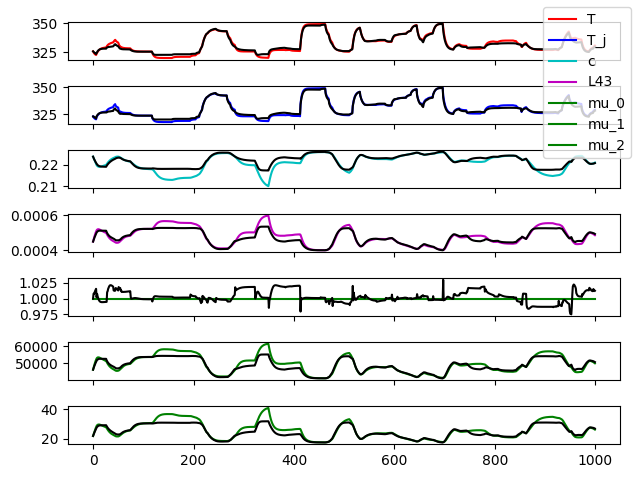

In [8]:
# Plot results
fig, ax = plt.subplots(7,1,sharex='col',sharey='row')

ax[0].plot(T_test[:,0],c='r', label='T')
ax[0].plot(x_narx[:,0],c='k')
ax[1].plot(T_j_test[:,0],c='b', label='T_j')
ax[1].plot(x_narx[:,1],c='k')
ax[2].plot(c_test[:,0],c='c', label='c')
ax[2].plot(x_narx[:,2],c='k')
ax[3].plot(L10_test[:,0],c='m', label='L43')
ax[3].plot(x_narx[:,3],c='k')
ax[4].plot(mu_0_test[:,0],c='g', label='mu_0')
ax[4].plot(x_narx[:,4],c='k')
ax[5].plot(mu_1_test[:,0],c='g', label='mu_1')
ax[5].plot(x_narx[:,5],c='k')
ax[6].plot(mu_2_test[:,0],c='g', label='mu_2')
ax[6].plot(x_narx[:,6],c='k')

fig.legend()
fig.tight_layout()

In [9]:
# Bayesian last layer
narx_train = [train_scaled[0].astype(np.float32),train_scaled[1].astype(np.float32)]
narx_val = [val_scaled[0].astype(np.float32),val_scaled[1].astype(np.float32)]
# Use different scaler for BLL
scaler_BLL = tools.Scaler(*narx_train)

# Fix seeds
seed = 1234
importlib.reload(functions)
np.random.seed(seed)
tf.random.set_seed(seed)
joint_model_bll, output_model_bll = functions.get_narx_model(narx_train, seed)


tf.keras.utils.plot_model(
    joint_model_bll,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)
# Get bll model
bllmodel = bll.BayesianLastLayer(joint_model_bll, scaler_BLL)
#Prepare training
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
optimizer = tf.keras.optimizers.experimental.AdamW(weight_decay=0.004)
#Setup training:
bllmodel.setup_training(optimizer)
# Get callback for early stopping
cb_early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=1e-4,
                    patience=40000,
                    verbose=True,
                    mode="auto",
                    baseline=None,
                    restore_best_weights=True,)


bllmodel.fit(*narx_train, val=narx_val, epochs=30000, verbose=True, callbacks=[cb_early_stopping])

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
# Test model
x_0 = y_test[0].reshape(1,-1)
x_narx = x_0.reshape(1,-1)

t_sim = y_test.shape[0]

for i in range(l-1):
    x_narx = np.concatenate((x_narx,x_0),axis=0)
for i in range(l,t_sim):
    print(i)
    #print('Step',i+1,'/',t_sim)
    x_this_step = []
    u_this_step = []
    x_this_step.append(x_narx[-l:])
    u_this_step.append(u_test[(i-l):i])
    
    x_this_step = np.array(x_this_step)
    u_this_step = np.array(u_this_step)
    
    narx_in_this_step = np.concatenate((x_this_step.reshape(1,-1),u_this_step.reshape(1,-1)),axis=1).reshape(1,-1)
    narx_in_this_step_sc = scaler_NN.scale(narx_in_this_step)[0]
    
    # narx_in_this_step_reduced = pca.transform(narx_in_this_step_sc)
    ##############################################################
    narx_in_this_step_reduced = narx_in_this_step_sc
    
    x_NN_sc, std = bllmodel.predict(narx_in_this_step_reduced.astype(np.float32),uncert_type='std',with_noise_variance=True)
    x_NN = scaler_NN.unscale(narx_in_this_step_sc,x_NN_sc)[1].astype(float)
    
    x_narx = np.concatenate((x_narx,x_NN),axis=0)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


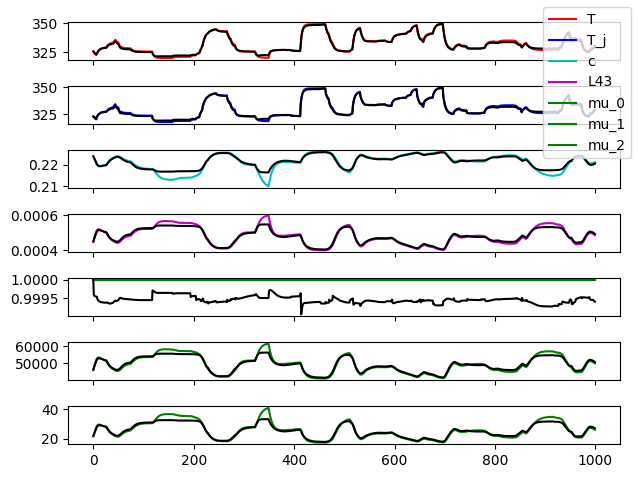

In [11]:
# Plot results
fig, ax = plt.subplots(7,1,sharex='col',sharey='row')

ax[0].plot(T_test[:,0],c='r', label='T')
ax[0].plot(x_narx[:,0],c='k')
ax[1].plot(T_j_test[:,0],c='b', label='T_j')
ax[1].plot(x_narx[:,1],c='k')
ax[2].plot(c_test[:,0],c='c', label='c')
ax[2].plot(x_narx[:,2],c='k')
ax[3].plot(L10_test[:,0],c='m', label='L43')
ax[3].plot(x_narx[:,3],c='k')
ax[4].plot(mu_0_test[:,0],c='g', label='mu_0')
ax[4].plot(x_narx[:,4],c='k')
ax[5].plot(mu_1_test[:,0],c='g', label='mu_1')
ax[5].plot(x_narx[:,5],c='k')
ax[6].plot(mu_2_test[:,0],c='g', label='mu_2')
ax[6].plot(x_narx[:,6],c='k')

fig.legend()
fig.tight_layout()

Export models to ONNX format

In [16]:
import tf2onnx

In [19]:
bllmodel.model

AttributeError: 'BayesianLastLayer' object has no attribute 'model'

In [21]:
onnx_model_NN, _ = tf2onnx.convert.from_keras(model_NN)
onnx_model_bll, _ = tf2onnx.convert.from_keras(joint_model_bll)

Pickle models

In [22]:
# Pickle BLL model, hyperparameters and scalers
fileo = open('./model_bll_500.pkl', 'wb')
pickle.dump(onnx_model_bll, fileo)
pickle.dump(bllmodel.Sigma_p_bar, fileo)
pickle.dump(bllmodel.log_sigma_e.numpy(), fileo)
pickle.dump(scaler_BLL, fileo)
pickle.dump(scaler_NN, fileo)
fileo.close()

# Pickle NN model and scaler
fileo = open('./model_NN_500.pkl', 'wb')
pickle.dump(onnx_model_NN, fileo)
pickle.dump(scaler_NN, fileo)
fileo.close()

In [14]:
fileo = open('./model_NN_500.pkl', 'wb')
pickle.dump(model_NN.layers[1].weights[0].numpy(), fileo)
pickle.dump(model_NN.layers[1].weights[1].numpy(), fileo)
pickle.dump(model_NN.layers[2].weights[0].numpy(), fileo)
pickle.dump(model_NN.layers[2].weights[1].numpy(), fileo)
pickle.dump(model_NN.layers[3].weights[0].numpy(), fileo)
pickle.dump(model_NN.layers[3].weights[1].numpy(), fileo)
pickle.dump(scaler_NN.scaler_x.scale_, fileo)
pickle.dump(scaler_NN.scaler_x.mean_, fileo)
pickle.dump(scaler_NN.scaler_y.scale_, fileo)
pickle.dump(scaler_NN.scaler_y.mean_, fileo)
fileo.close()


fileo = open('./model_bll_500.pkl', 'wb')
pickle.dump(joint_model_bll.layers[1].weights[0].numpy(), fileo)
pickle.dump(joint_model_bll.layers[1].weights[1].numpy(), fileo)
pickle.dump(joint_model_bll.layers[2].weights[0].numpy(), fileo)
pickle.dump(joint_model_bll.layers[2].weights[1].numpy(), fileo)
pickle.dump(joint_model_bll.layers[3].weights[0].numpy(), fileo)
pickle.dump(joint_model_bll.layers[3].weights[1].numpy(), fileo)
pickle.dump(bllmodel.Sigma_p_bar, fileo)
pickle.dump(bllmodel.log_sigma_e.numpy(), fileo)
pickle.dump(scaler_NN.scaler_x.scale_, fileo)
pickle.dump(scaler_NN.scaler_x.mean_, fileo)
pickle.dump(scaler_NN.scaler_y.scale_, fileo)
pickle.dump(scaler_NN.scaler_y.mean_, fileo)
pickle.dump(scaler_BLL.scaler_x.scale_, fileo)
pickle.dump(scaler_BLL.scaler_x.mean_, fileo)
pickle.dump(scaler_BLL.scaler_y.scale_, fileo)
pickle.dump(scaler_BLL.scaler_y.mean_, fileo)
fileo.close()